# Dev Interp - Grokking Modular Addition and Multiplication

# Setup

In [131]:
TRAIN_MODEL = False

In [132]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
import os

DEVELOPMENT_MODE = True
IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")

    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

if IN_COLAB or IN_GITHUB:
    %pip install transformer_lens
    %pip install circuitsvis

Running as a Jupyter notebook - intended for development only!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/85/m4tlmmlj4w58khykxvwgvt980000gn/T/ipykernel_905/2858945602.py:22: DeprecationWarning:

`magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).

/var/folders/85/m4tlmmlj4w58khykxvwgvt980000gn/T/ipykernel_905/2858945602.py:23: DeprecationWarning:

`magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).



In [133]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: notebook_connected


In [134]:
pio.templates['plotly'].layout.xaxis.title.font.size = 20
pio.templates['plotly'].layout.yaxis.title.font.size = 20
pio.templates['plotly'].layout.title.font.size = 30

In [135]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import os
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [136]:
import transformer_lens.utils as utils
from transformer_lens import HookedTransformer, HookedTransformerConfig

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"device: {device}")

device: cpu


Plotting helper functions:

In [137]:
from collections import deque

def rolling_average(values, window_size):
    window = deque(maxlen=window_size)
    averages = []
    
    for value in values:
        window.append(value)
        averages.append(sum(window) / len(window))
    
    return averages

def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

# Model Training

In [138]:
DATA_SEED = 598

## Create the dataset
* Define modular addition and modular multiplication datasets
* Combine the two data sets
* We can vary the proportion of addition to multiplication in the training dataset

In [139]:
import pandas as pd
from torch.utils.data import TensorDataset

max_nums = 130
mod_value = 113

# The fraction of the data that should be used for training (not all of the rest will be used for testing)
train_frac = 0.475

# The fraction of the training data that should be addition (the rest will be multiplication)
addition_frac = 0.684

def create_dataset(max_nums: int, addition: bool, mod_value: int):
    data = list()
    for a in range(max_nums):
        for b in range(max_nums):
            if addition:
                label = (a + b) % mod_value
            else:
                label = (a * b) % mod_value
            data.append([[a, int(addition), b], label])

    return pd.DataFrame(data, columns=["input", "label"])

addition_df = create_dataset(max_nums, True, mod_value)
multiplication_df = create_dataset(max_nums, False, mod_value)

print(f"Addition dataset size = {len(addition_df)}")
print(f"Multiplication dataset size = {len(multiplication_df)}")

total_train_size = int((len(addition_df) + len(multiplication_df)) * train_frac)

print(f"Total train size = {total_train_size}")
# Calculate the sizes for train datasets based on the desired proportion
add_train_size = int(total_train_size * addition_frac)
multi_train_size = total_train_size - add_train_size

# Determine the size for test datasets (use the remaining data, but ensure equal sizes)
test_size = min(len(addition_df) - add_train_size, len(multiplication_df) - multi_train_size)

# Create train datasets
add_train_df = addition_df.sample(n=add_train_size, random_state=DATA_SEED)
multi_train_df = multiplication_df.sample(n=multi_train_size, random_state=DATA_SEED)

# Create test datasets with equal size
add_test_df = addition_df.drop(add_train_df.index).sample(n=test_size, random_state=DATA_SEED)
multi_test_df = multiplication_df.drop(multi_train_df.index).sample(n=test_size, random_state=DATA_SEED)

# Print sizes for verification
print(f"Addition train size = {len(add_train_df)}")
print(f"Addition test size = {len(add_test_df)}")
print(f"Multiplication train size = {len(multi_train_df)}")
print(f"Multiplication test size = {len(multi_test_df)}")

print(f"Addition: {len(add_train_df)/(len(add_train_df) + len(multi_train_df))*100:0.1f}% \
Multiplication: {len(multi_train_df)/(len(add_train_df) + len(multi_train_df))*100:0.1f}%")

# Combine and shuffle the datasets
train_df = pd.concat([add_train_df, multi_train_df], ignore_index=True).sample(frac=1, random_state=DATA_SEED).reset_index(drop=True)
test_df = pd.concat([add_test_df, multi_test_df], ignore_index=True).sample(frac=1, random_state=DATA_SEED).reset_index(drop=True)

print(f"Combined dataset = {len(train_df) + len(test_df)}")

print(f"Train size = {len(train_df)}")
print(f"Test size = {len(test_df)}")

# Create the dataloaders
def get_dataloader(df, batch_size, shuffle):
    inputs = torch.tensor(df['input'].tolist())
    labels = torch.tensor(df['label'].tolist())
    dataset = TensorDataset(inputs, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = get_dataloader(train_df, 1024, shuffle=True)
test_loader = get_dataloader(test_df, len(test_df), shuffle=False)

train_data = torch.tensor(train_df['input'].tolist())
train_labels = torch.tensor(train_df['label'].tolist())

test_data = torch.tensor(test_df['input'].tolist())
test_labels = torch.tensor(test_df['label'].tolist())

add_test_data = torch.tensor(add_test_df['input'].tolist())
add_test_labels = torch.tensor(add_test_df['label'].tolist())

multi_test_data = torch.tensor(multi_test_df['input'].tolist())
multi_test_labels = torch.tensor(multi_test_df['label'].tolist())

print(f"train_data.shape = {train_data.shape}")
print(f"train_labels.shape = {train_labels.shape}")
print(f"test_data.shape = {test_data.shape}")
print(f"test_labels.shape = {test_labels.shape}")
print(f"train_data[:10] = {train_data[:10]}")


Addition dataset size = 16900
Multiplication dataset size = 16900
Total train size = 16055
Addition train size = 10981
Addition test size = 5919
Multiplication train size = 5074
Multiplication test size = 5919
Addition: 68.4% Multiplication: 31.6%
Combined dataset = 27893
Train size = 16055
Test size = 11838
train_data.shape = torch.Size([16055, 3])
train_labels.shape = torch.Size([16055])
test_data.shape = torch.Size([11838, 3])
test_labels.shape = torch.Size([11838])
train_data[:10] = tensor([[ 63,   1,  53],
        [ 58,   0,  22],
        [ 37,   1,   6],
        [ 58,   1, 103],
        [ 70,   1,  58],
        [120,   1, 119],
        [ 28,   1, 111],
        [ 49,   0,  80],
        [118,   1,  96],
        [ 44,   1,   2]])


## Define Model

In [140]:

cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 4,
    d_model = 128,
    d_head = 32,
    d_mlp = 512,
    act_fn = "relu",
    normalization_type="LN",
    d_vocab=max_nums+1,
    d_vocab_out=mod_value,
    n_ctx= train_data.shape[1],
    init_weights=True,
    device=device,
    seed = 999,
)

model = HookedTransformer(cfg)

Disable the biases, as we don't need them for this task and it makes things easier to interpret.

In [141]:
for name, param in model.named_parameters():
    if "b_" in name:
        param.requires_grad = False


## Define Optimizer + Loss

In [142]:
# Optimizer config
lr = 1e-3
wd = 1.
betas = (0.90, 0.98)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)

In [143]:
def loss_fn(logits, labels):
    if len(logits.shape)==3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])[:, 0]
    return -correct_log_probs.mean()

train_logits = model(train_data)
train_loss = loss_fn(train_logits, train_labels)
print(f"train_loss = {train_loss}")
test_logits = model(test_data)
test_loss = loss_fn(test_logits, test_labels)
print(f"test_loss = {test_loss}")

train_loss = 5.047642391787601
test_loss = 5.06579144378938


## Actually Train

In [144]:
num_epochs = 6000
checkpoint_every = 100
train_losses = []
test_losses = []
add_test_losses = []
multi_test_losses = []
model_checkpoints = []
checkpoint_epochs = []
if TRAIN_MODEL:
    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        train_logits = model(train_data)
        train_loss = loss_fn(train_logits, train_labels)
        train_loss.backward()
        train_losses.append(train_loss.item())
        optimizer.step()
        optimizer.zero_grad()

        model.eval()
        with torch.inference_mode():
            # General test loss
            test_logits = model(test_data)
            test_loss = loss_fn(test_logits, test_labels)
            test_losses.append(test_loss.item())

            if (epoch+1) % 10 == 0:
                # Addition test loss
                add_test_logits = model(add_test_data)
                add_test_loss = loss_fn(add_test_logits, add_test_labels)
                add_test_losses.append(add_test_loss.item())

                # Multiplication test loss
                multi_test_logits = model(multi_test_data)
                multi_test_loss = loss_fn(multi_test_logits, multi_test_labels)
                multi_test_losses.append(multi_test_loss.item())

        if ((epoch+1)%checkpoint_every)==0:
            checkpoint_epochs.append(epoch)
            model_checkpoints.append(copy.deepcopy(model.state_dict()))
            print(f"Epoch {epoch} Train Loss {train_loss.item()} Test Loss {test_loss.item()} Add Test Loss {add_test_loss.item()} Multi Test Loss {multi_test_loss.item()}")

In [145]:
PTH_LOCATION = "../saves/grokking_add_multi_68%_addition_47.5%_train.pth"
if TRAIN_MODEL:
    # Create the directory if it does not exist
    os.makedirs(Path(PTH_LOCATION).parent, exist_ok=True)
    
    print(f"len(train_losses) = {len(train_losses)} len(test_losses) = {len(test_losses)} len(model_checkpoints) = {len(model_checkpoints)}")
    torch.save(
        {
            "model":model.state_dict(),
            "config": model.cfg,
            "checkpoints": model_checkpoints,
            "checkpoint_epochs": checkpoint_epochs,
            "test_losses": test_losses,
            "train_losses": train_losses,
            "add_test_losses": add_test_losses,
            "multi_test_losses": multi_test_losses,
            "max_nums": max_nums,
            "mod_value": mod_value,
            "train_frac": train_frac,
            "addition_frac": addition_frac,
        },
        PTH_LOCATION)

In [146]:
LOAD_LOCATION = "../saves/grokking_add_multi_0.7.pth"
if not TRAIN_MODEL:
    cached_data = torch.load(LOAD_LOCATION, weights_only=False)
    model.load_state_dict(cached_data['model'])
    model_checkpoints = cached_data["checkpoints"]
    checkpoint_epochs = cached_data["checkpoint_epochs"]
    test_losses = cached_data['test_losses']
    train_losses = cached_data['train_losses']
    add_test_losses = cached_data['add_test_losses']
    multi_test_losses = cached_data['multi_test_losses']
    max_nums = cached_data['max_nums']
    mod_value = cached_data['mod_value']
    train_frac = cached_data['train_frac']
    addition_frac = cached_data['addition_frac']
    print(f"train_frac = {train_frac} addition_frac = {addition_frac}")
    print(f"len(train_losses) = {len(train_losses)} len(test_losses) = {len(test_losses)} len(model_checkpoints) = {len(model_checkpoints)}")

train_frac = 0.5 addition_frac = 0.7
len(train_losses) = 5000 len(test_losses) = 5000 len(model_checkpoints) = 50


In [147]:
test_logits = model(test_data)
test_loss = loss_fn(test_logits, test_labels)
print(f"test_loss = {test_loss}")

test_loss = 0.30149553907995896


## Show Model Training Statistics, Check that it groks!

In [148]:
from neel_plotly.plot import line
step = 10
average_window = 200
train_losses_avg = rolling_average(train_losses, average_window)
test_losses_avg = rolling_average(test_losses, average_window)
add_test_losses_avg = rolling_average(add_test_losses, average_window//10)
multi_test_losses_avg = rolling_average(multi_test_losses, average_window//10)

line([train_losses[::step], test_losses[::step], add_test_losses, multi_test_losses], x=np.arange(0, len(train_losses_avg), step), xaxis="Epoch", yaxis="Loss", log_y=False, title=f"Training Curve for Modular Arithmetic - {addition_frac*100:.0f}% Addition", line_labels=['train loss', 'test loss', 'add loss', 'multi loss'], toggle_x=True, toggle_y=True)
line([train_losses_avg[::step], test_losses_avg[::step], add_test_losses_avg, multi_test_losses_avg], x=np.arange(0, len(train_losses_avg), step), xaxis="Epoch", yaxis="Rolling Avg Loss", log_y=False, title=f"Training Curve for Modular Arithmetic - {addition_frac*100:.0f}% Addition", line_labels=['train', 'test', 'add loss', 'multi loss'], toggle_x=True, toggle_y=True)

### Estiamtating Local Learning Coefficient (RLCT)

In [206]:
from devinterp.slt.sampler import estimate_learning_coeff_with_summary, estimate_learning_coeff, SGLD
from devinterp.utils import plot_trace

def evaluate(model, data):
    inputs, outputs = data

    return loss_fn(model(inputs), outputs), {
        "logits": model(inputs)
    }

llc_estimates_sgld = []
llc_estimates_sgld = []

for saved_model in tqdm.tqdm(model_checkpoints):
    model.load_state_dict(saved_model)
    result = estimate_learning_coeff(
                model,
                loader=train_loader,
                evaluate=evaluate,
                sampling_method=SGLD,
                optimizer_kwargs=dict(lr=5e-4, localization=100.0),
                num_chains=15,           # How many independent chains to run
                num_draws=5,            # How many samples to draw per chain
                num_burnin_steps=20,    # How many samples to discard at the beginning of each chain
                num_steps_bw_draws=1,   # How many steps to take between each sample
                device=device,
                #online=True,
            )
    llc_estimates.append(result)
    print(f"result = {result}")
'''
    plot_trace(
        results["llc/trace"],
        "Loss",
        x_axis="Step",
        title=f"Loss Trace, avg LLC = {sum(results['llc/means']) / len(results['llc/means']):.2f}",
        plot_mean=False,
        plot_std=False,
        fig_size=(12, 9),
        true_lc=None,
    )
'''
# Graph the LLC estimates
line(llc_estimates, xaxis="Epoch", yaxis="LLC", title="Learning Coefficient Estimates", log_y=False, toggle_x=True, toggle_y=True)

  0%|          | 0/50 [00:00<?, ?it/s]

/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:54: UserWarning:

nbeta not set - using default nbeta.



Moving model to device:  cpu
Moving model to device:  cpu


/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:234: UserWarning:

If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.



Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 41.78it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 34.44it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 36.99it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 41.57it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 42.17it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 39.61it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 42.29it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 42.46it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 41.81it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 36.19it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 35.58it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 38.80it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 35.01it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 32.18it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 39.16it/s]


result = 454.82647705078125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 41.18it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 41.48it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 41.25it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 38.91it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 35.24it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 40.76it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 39.26it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 40.94it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 38.24it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 41.27it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 41.08it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 40.60it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 39.38it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 36.74it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 39.06it/s]


result = 773.5372314453125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 38.48it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 40.32it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 39.11it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 40.89it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 40.78it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 40.61it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 41.24it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 38.36it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 40.05it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:01<00:00, 14.13it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 32.96it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 27.54it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 37.54it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 38.73it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 36.63it/s]


result = 811.586669921875
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 36.08it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 39.13it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 38.05it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 37.76it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 36.89it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 33.47it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 39.34it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 38.59it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 37.77it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 32.93it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 38.07it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 38.78it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 38.38it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 36.66it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 38.01it/s]


result = 821.6535034179688
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 32.96it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 38.50it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 36.85it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 38.19it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 38.62it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 38.45it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 36.37it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 38.27it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 37.91it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 37.63it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 30.68it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 38.75it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 37.73it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 37.68it/s]


result = 820.9591674804688
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 35.99it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 38.06it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 39.20it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 38.68it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 38.18it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 35.11it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 37.91it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 37.46it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 37.01it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 35.00it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 37.09it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 36.98it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 37.50it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 35.05it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 35.95it/s]


result = 825.1616821289062
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 30.94it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 34.48it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 35.57it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 36.19it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 36.60it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 34.30it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 34.94it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 36.95it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 35.24it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 30.49it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 36.69it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 36.64it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 34.43it/s]


result = 827.345458984375
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 35.27it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 34.40it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 34.21it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 32.56it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 34.57it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 35.32it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 29.36it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 33.01it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 34.25it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 34.91it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 34.59it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 32.67it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 34.58it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 34.31it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 35.11it/s]


result = 825.9927368164062
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 32.35it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 29.26it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 35.00it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 31.08it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 32.19it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 33.90it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 34.22it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 34.57it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 32.74it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 34.58it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 33.92it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 34.70it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 28.63it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 35.11it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 35.06it/s]


result = 814.1217651367188
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 34.32it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 31.90it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 34.76it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 33.61it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 34.39it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 31.14it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 29.33it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 31.54it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 33.82it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 32.98it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 33.70it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 34.05it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 34.17it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 31.96it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 33.94it/s]


result = 810.0178833007812
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 34.14it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 29.64it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 32.21it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 34.76it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 33.53it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 33.87it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 32.17it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 34.02it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 33.54it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 34.17it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 32.07it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 33.18it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 33.76it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 28.97it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 32.01it/s]


result = 807.298828125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 33.79it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 33.31it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 33.64it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 31.24it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 33.38it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 33.56it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 33.20it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 31.11it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 28.54it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 33.28it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 33.49it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 33.53it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 31.64it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 33.92it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 33.24it/s]


result = 798.8726806640625
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 31.27it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 31.18it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 28.60it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 33.73it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 33.97it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 31.63it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 33.71it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 33.51it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 33.22it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 31.65it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 32.94it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 32.12it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 33.33it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 27.30it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 33.51it/s]


result = 794.922607421875
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 33.96it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 33.56it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 31.54it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 32.64it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 33.25it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 32.95it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 30.53it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 33.25it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 28.49it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 33.47it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 31.98it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 33.26it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 33.73it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 33.81it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 31.86it/s]


result = 770.2195434570312
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 33.44it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 33.46it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 26.83it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 31.19it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 32.85it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 32.82it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 32.95it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 30.54it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 28.39it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 32.65it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 33.00it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 31.05it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 32.76it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 32.81it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 28.77it/s]


result = 786.487548828125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 31.04it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 32.13it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 32.01it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 32.92it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 31.04it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 32.54it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 32.68it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 32.52it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 30.93it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 27.67it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 32.82it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 33.19it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 31.32it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 32.55it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 33.07it/s]


result = 793.6002197265625
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 32.03it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 30.52it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 33.49it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 26.49it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 31.13it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 31.40it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 32.46it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 32.93it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 35.37it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 32.96it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 34.94it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 35.76it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 35.28it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 32.81it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 35.07it/s]


result = 784.0667724609375
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 36.13it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 34.95it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 32.99it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 34.77it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 34.74it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 33.82it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 33.26it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 34.10it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 35.02it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 35.01it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 29.72it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 33.48it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 35.05it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 35.15it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 33.98it/s]


result = 782.9607543945312
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 32.73it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 34.90it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 35.31it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 35.46it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 28.14it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 35.17it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 34.50it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 34.38it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 35.18it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 32.77it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 34.22it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 34.61it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 33.98it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 32.20it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 34.22it/s]


result = 755.2130737304688
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 32.61it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 33.88it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 32.15it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 34.84it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 34.59it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 34.28it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 33.32it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 35.20it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 34.10it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 34.95it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 29.29it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 32.40it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 34.05it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 34.42it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 34.68it/s]


result = 776.864990234375
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 32.53it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 34.51it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 34.34it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 35.26it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 32.79it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 28.96it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 34.03it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 34.22it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 32.50it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 34.16it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 34.20it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 34.33it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 33.31it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 34.25it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 34.13it/s]


result = 781.9591064453125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 35.01it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 32.21it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 34.02it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 33.72it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 33.97it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 34.22it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 33.40it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 34.42it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 34.93it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 34.48it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 33.16it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 29.13it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 34.34it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 35.02it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 34.31it/s]


result = 777.8566284179688
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 34.34it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 34.63it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 34.24it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 34.66it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 32.44it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 34.33it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 29.80it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 33.70it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 33.35it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 34.35it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 34.95it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 34.47it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 32.29it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 34.11it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 34.35it/s]


result = 778.5543823242188
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 34.35it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 27.85it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 35.09it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 31.14it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 33.18it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 31.22it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 33.51it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 34.05it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 32.00it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 33.36it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 34.55it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 35.00it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 27.70it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 32.77it/s]


result = 778.4385375976562
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 33.49it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 32.64it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 29.93it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 33.43it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 34.23it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 34.10it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 31.05it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 33.46it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 28.58it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 30.97it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 31.18it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 33.68it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 33.23it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 31.55it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 33.56it/s]


result = 778.4865112304688
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 33.47it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 33.46it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 31.30it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 27.69it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 33.73it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 33.43it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 30.51it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 31.85it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 32.07it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 32.17it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 31.31it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 29.97it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 32.44it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 32.38it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 27.52it/s]


result = 772.8593139648438
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 29.21it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 31.09it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 29.62it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 30.92it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 29.51it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 31.55it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 31.52it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 31.67it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 30.02it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 26.64it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 31.39it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 31.69it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 32.05it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 29.24it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 31.30it/s]


result = 774.6428833007812
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 31.36it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 30.42it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 29.06it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 30.99it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 26.23it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 31.75it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 29.34it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 30.95it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 30.72it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 30.29it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 29.22it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 30.40it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 29.36it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 30.61it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 27.11it/s]


result = 780.8536376953125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 30.17it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 30.52it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 25.73it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:01<00:00, 24.14it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 28.16it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 28.45it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 28.74it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 28.72it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 29.05it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 29.07it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 29.69it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:01<00:00, 24.25it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 29.49it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 29.24it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 29.07it/s]


result = 779.579345703125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 29.12it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 29.82it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 29.54it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 28.42it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 30.36it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 25.65it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 30.39it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 28.36it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 30.15it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 29.86it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 29.40it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 27.10it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 29.60it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 29.61it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 29.69it/s]


result = 773.6299438476562
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 25.43it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 28.83it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 29.62it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 27.47it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 29.24it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 29.61it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 29.71it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 28.86it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 29.13it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 29.57it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 30.39it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:01<00:00, 24.03it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 30.15it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 29.50it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 29.07it/s]


result = 776.7307739257812
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 29.41it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 29.56it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 29.51it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 28.14it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 29.12it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 29.64it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:01<00:00, 24.38it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 28.64it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 30.23it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 30.01it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 29.38it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 27.83it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 30.19it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 29.73it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 31.57it/s]


result = 774.9265747070312
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:01<00:00, 24.53it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 30.28it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 29.96it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 30.72it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 28.04it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 30.12it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 29.51it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 29.52it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 27.54it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 28.74it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 28.26it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 28.91it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:01<00:00, 24.53it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 29.61it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 30.15it/s]


result = 651.627685546875
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 28.35it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 30.30it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 30.23it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 29.76it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 29.25it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 29.93it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 30.18it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 25.21it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 28.03it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 29.23it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 29.87it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 29.51it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 28.09it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 29.85it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 29.22it/s]


result = 770.5020751953125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 28.36it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 30.51it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 26.15it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 30.86it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 28.18it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 29.21it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 27.51it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 29.54it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 27.44it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 28.94it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 29.84it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 29.13it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 27.97it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 25.38it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 28.81it/s]


result = 767.6594848632812
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 27.50it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 29.08it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 29.65it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 29.68it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 28.00it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 30.29it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 29.58it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 30.26it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:01<00:00, 24.35it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 29.03it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 30.28it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 29.46it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:01<00:00, 24.93it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 29.06it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 29.24it/s]


result = 771.3953247070312
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 28.20it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 29.55it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 29.60it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:01<00:00, 24.72it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 26.87it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 29.35it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 30.17it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 30.37it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 28.87it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 30.24it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 30.98it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 31.14it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 29.68it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 31.27it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 26.02it/s]


result = 777.0797119140625
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 29.04it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 30.29it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 30.48it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 30.43it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 28.35it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 30.35it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 30.83it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 29.44it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 28.34it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 25.43it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 30.42it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 29.90it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 28.87it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 29.91it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 29.84it/s]


result = 778.7067260742188
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 25.91it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 30.69it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 30.97it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 25.33it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 28.24it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 29.30it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 30.20it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 29.74it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 27.31it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 29.86it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 29.61it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 29.90it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 27.44it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 29.96it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 30.08it/s]


result = 776.1710815429688
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 28.50it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 30.69it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 28.74it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 30.19it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 28.91it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 29.38it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 30.05it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 30.15it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 28.05it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 29.37it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 25.52it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 30.25it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 28.82it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 30.07it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 30.84it/s]


result = 768.2284545898438
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 28.05it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 30.14it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 26.32it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 26.10it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:01<00:00, 24.54it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 30.99it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 29.91it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 30.34it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 28.49it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 30.56it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 30.58it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 30.19it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 27.96it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 29.65it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 29.72it/s]


result = 763.5393676757812
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 27.89it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 29.36it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 29.52it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 29.12it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 27.30it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 25.06it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 27.12it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 27.09it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 26.43it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:01<00:00, 24.40it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 28.47it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 26.91it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 28.81it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 29.12it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 28.29it/s]


result = 767.5942993164062
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 27.37it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 28.22it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 28.13it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 27.02it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:01<00:00, 24.02it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 29.13it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 28.03it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 26.62it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 28.25it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 29.02it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 28.11it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 28.04it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 28.48it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 28.54it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 28.92it/s]


result = 770.8662719726562
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 28.78it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 28.07it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 29.37it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 27.83it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 28.30it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 27.88it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 26.58it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 29.01it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 28.75it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 28.42it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:01<00:00, 23.30it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 28.87it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 28.55it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 28.68it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 26.59it/s]


result = 772.5802612304688
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 26.45it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 28.37it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 26.62it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 28.52it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 28.63it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:01<00:00, 23.78it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:01<00:00, 24.84it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 28.79it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 28.12it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 27.61it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 27.61it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 28.27it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 28.12it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 27.11it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 28.86it/s]


result = 775.4881591796875
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 28.92it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 27.63it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 28.76it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 29.33it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 29.29it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 25.88it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 29.21it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 28.55it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 27.99it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 26.49it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 29.40it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:01<00:00, 24.50it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 27.79it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 29.26it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 30.00it/s]


result = 770.8507080078125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 28.42it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 27.04it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 25.99it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 28.85it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 26.58it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:01<00:00, 23.57it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 27.61it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 25.83it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 28.83it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 28.18it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 28.21it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 26.63it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 28.36it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 28.42it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 26.73it/s]


result = 766.5172729492188
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:01<00:00, 24.69it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 28.69it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 27.26it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 27.20it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 27.87it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 28.65it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 27.41it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 28.06it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 28.09it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 28.12it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 26.93it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 29.01it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:01<00:00, 24.18it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 29.02it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 26.68it/s]


result = 767.0591430664062
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 28.85it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 29.39it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 26.85it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 28.74it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 28.81it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 29.66it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 27.10it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:01<00:00, 24.27it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 28.97it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 27.21it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 27.79it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 28.13it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 29.11it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 27.04it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 28.45it/s]


result = 771.2996215820312
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 28.83it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:01<00:00, 22.54it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 27.65it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 27.74it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 27.03it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 28.52it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 28.76it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 28.87it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 27.26it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 28.05it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 27.69it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 28.27it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:01<00:00, 23.69it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 28.34it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 28.04it/s]

result = 777.3110961914062


In [207]:
line(llc_estimates, xaxis="Epoch", yaxis="LLC", title="Learning Coefficient Estimates", log_y=False, toggle_x=True, toggle_y=True)

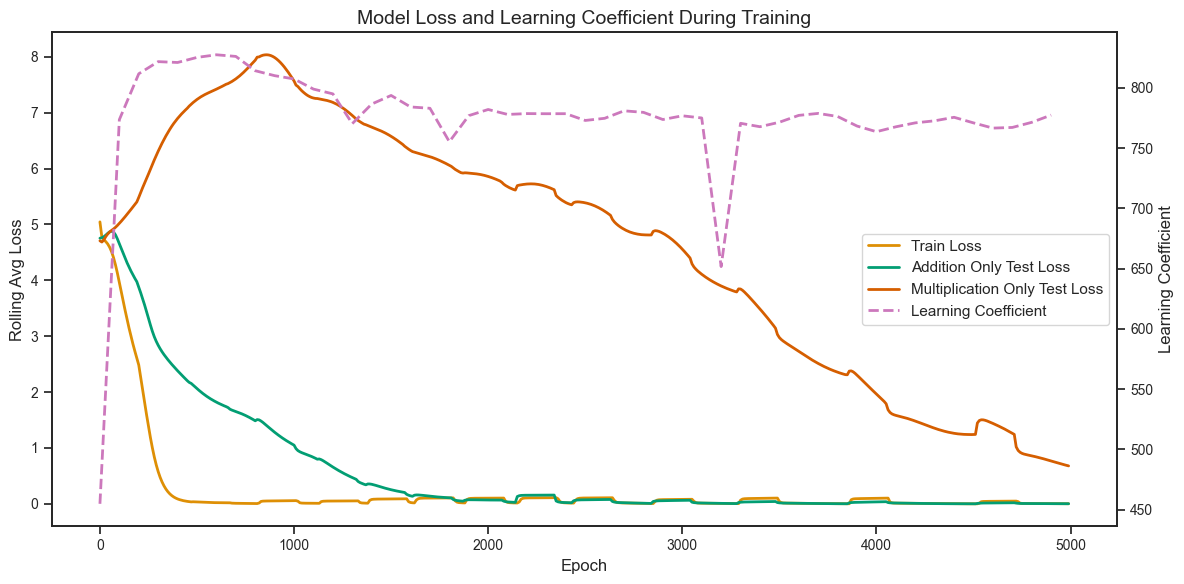

In [270]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your data prepared as before
epochs = np.arange(0, 5000, 10)
lc_epochs = np.arange(0, 5000, 100)

# Set up the plot
plt.figure(figsize=(12, 6))
sns.set_style("ticks")

# Create the main axis
ax1 = plt.gca()

# Plot loss curves
#ax1.plot(epochs, test_losses_avg[::10], color=colors[0], label='Test Loss', linewidth=2)
ax1.plot(epochs, train_losses_avg[::10], color=colors[1], label='Train Loss', linewidth=2)
ax1.plot(epochs, add_test_losses_avg, color=colors[2], label='Addition Only Test Loss', linewidth=2)
ax1.plot(epochs, multi_test_losses_avg, color=colors[3], label='Multiplication Only Test Loss', linewidth=2)

# Set up the second y-axis for learning coefficient
ax2 = ax1.twinx()
ax2.plot(lc_epochs, llc_estimates, color=colors[4], linestyle='--', label='Learning Coefficient', linewidth=2)

# Customize the plot
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Rolling Avg Loss', fontsize=12)
ax2.set_ylabel('Learning Coefficient', fontsize=12)
plt.title('Model Loss and Learning Coefficient During Training', fontsize=14)

# Adjust tick parameters
ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='y', which='major', labelsize=10)

# Create a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right') # bbox_to_anchor=(1.1, 1), fontsize=10)

plt.tight_layout()
plt.show()